# Proyek Klasifikasi Text: [Klasifikasi Emosi]
- ID team capstone :LAI25-SM061


Proyek ini bertujuan untuk mengembangkan model klasifikasi emosi berbasis teks dalam bahasa Indonesia menggunakan pendekatan hybrid yang menggabungkan model DistilBERT pre-trained dengan fitur berbasis TF-IDF dan model Logistic Regression dari scikit-learn untuk mengidentifikasi empat kelas emosi: happy, sadness, fear, dan stress. Dataset dikumpulkan dari berbagai sumber publik (happy_db, train.txt, val.txt, test.txt, stress_dataset.txt, dan dataset_negatif.txt) serta diperkaya dengan augmentasi data manual untuk menyeimbangkan distribusi kelas. Pendekatan hybrid ini dirancang untuk meningkatkan akurasi prediksi, terutama pada teks dengan konteks budaya lokal Indonesia, dengan memanfaatkan kekuatan konteks semantik DistilBERT dan pola frekuensi kata dari TF-IDF. Model DistilBERT dioptimalkan untuk deployment pada perangkat mobile melalui konversi ke format TFLite, sementara model hybrid memberikan alternatif ringan untuk inferensi cepat.

Model utama menggunakan DistilBERT pre-trained (distilbert-base-multilingual-cased) dari Hugging Face, dipilih karena kemampuan multibahasanya yang mendukung bahasa Indonesia dan ukurannya yang lebih ringan dibandingkan BERT standar, menjadikannya ideal untuk aplikasi mobile. Pendekatan hybrid melengkapi DistilBERT dengan Logistic Regression yang memanfaatkan logits DistilBERT dan fitur TF-IDF, menggantikan penyesuaian logits berbasis kata kunci dengan model yang terlatih secara otomatis untuk generalisasi yang lebih baik.

Berikut adalah detail perubahan, tuning, dan pengembangan yang dilakukan pada model:

1) Fine-Tuning Model DistilBERT:
- Model DistilBERT diinisialisasi dengan bobot pre-trained dan di-fine-tune untuk tugas klasifikasi empat kelas emosi (happy, sadness, fear, stress).

- Dataset dikombinasikan dari sumber eksternal dan augmentasi manual untuk memperkaya representasi kelas. Augmentasi mencakup 42 sampel untuk happy, 21 untuk fear, 12 untuk sadness, dan 25 untuk stress, menangani ketidakseimbangan kelas.

- Penyeimbangan data dilakukan dengan mengambil 2600 sampel per kelas menggunakan undersampling untuk kelas happy dan augmentasi untuk kelas lain, memastikan distribusi yang merata.

2) Custom Focal Loss:
- Mengimplementasikan CustomTrainer dengan focal loss untuk menangani ketidakseimbangan kelas dan meningkatkan fokus pada sampel yang sulit diklasifikasikan. Parameter focal loss:
  - Alpha: [6.0, 3.0, 4.0, 0.01] untuk memberikan bobot lebih pada kelas happy, sadness, dan fear, serta bobot rendah pada stress untuk mengurangi bias prediksi terhadap kelas ini.

  - Gamma: 3.0 untuk memperkuat fokus pada sampel dengan prediksi yang kurang akurat.

- Pendekatan ini meningkatkan sensitivitas model terhadap kelas minoritas dan mengurangi overfitting pada kelas mayoritas.

3) Hyperparameter Tuning:
- TrainingArguments disesuaikan untuk optimasi pelatihan:
  - Jumlah epoch: 10.

  - Batch size: 8, dengan gradient accumulation steps = 4 untuk mensimulasikan batch size lebih besar.

  - Learning rate: 3e-5 dengan cosine scheduler untuk penyesuaian laju pembelajaran yang halus.

  - Warmup steps: 200 untuk stabilisasi pelatihan awal.

  - Weight decay: 0.1 untuk regularisasi guna mencegah overfitting.

  - Early stopping dengan patience 5 berdasarkan metrik F1-score untuk menghentikan pelatihan saat performa tidak meningkat.

  - Mixed precision training (fp16) digunakan jika GPU tersedia untuk meningkatkan efisiensi komputasi.

4) Preprocessing dan Tokenisasi:
- Tokenizer DistilBERT digunakan dengan parameter max_length=128, padding, dan truncation untuk menyesuaikan panjang teks.

- Dataset dikonversi ke format PyTorch dengan kolom input_ids, attention_mask, labels, dan text untuk mendukung pelatihan dan ekstraksi fitur hybrid. Kolom text dipertahankan untuk keperluan ekstraksi TF-IDF dan logits.

5) Pendekatan Hybrid dengan Logistic Regression:
- Menggantikan penyesuaian logits berbasis kata kunci dengan pendekatan hybrid yang lebih terstruktur:
  - Logits DistilBERT diekstrak untuk setiap teks sebagai representasi konteks semantik.

  - Fitur TF-IDF dihasilkan menggunakan TfidfVectorizer (max_features=5000) untuk menangkap pola frekuensi kata, mirip dengan logika kata kunci tetapi lebih skalabel.

  - Fitur gabungan (logits + TF-IDF) digunakan untuk melatih model Logistic Regression (multi_class='multinomial', C=1.0, max_iter=1000), yang mempelajari bobot optimal untuk prediksi.

- Pendekatan ini meningkatkan generalisasi dibandingkan aturan kata kunci manual, terutama untuk teks dengan variasi bahasa atau frasa budaya lokal (misalnya, "hati kecilku").

- Model hybrid lebih ringan untuk inferensi dibandingkan DistilBERT penuh, cocok untuk lingkungan dengan sumber daya terbatas.

6) Konversi ke TFLite:
- Model DistilBERT dikonversi dari format PyTorch ke TensorFlow menggunakan TFDistilBertForSequenceClassification.

- Model disimpan sebagai SavedModel dan dikonversi ke format TFLite untuk deployment di perangkat mobile.

- Tokenizer disimpan terpisah untuk mendukung inferensi di aplikasi mobile.

- Inferensi TFLite divalidasi pada teks uji untuk memastikan fungsionalitas model setelah konversi.

7) Evaluasi dan Visualisasi:
- Model hybrid dan DistilBERT murni dievaluasi menggunakan metrik accuracy dan F1-score (weighted) pada dataset validasi dan pengujian.

- Classification report dihasilkan untuk menganalisis precision, recall, dan F1-score per kelas.

- Confusion matrix divisualisasikan menggunakan Seaborn untuk memahami pola kesalahan prediksi, memungkinkan perbandingan performa antara model hybrid dan DistilBERT murni.

- Visualisasi EDA (histogram panjang teks, box plot, dan count plot) dilakukan untuk memahami distribusi data sebelum pelatihan.






## Import Semua Packages/Library yang Digunakan

Mengimpor semua pustaka dan dependensi yang diperlukan untuk proyek. Pertama, perintah !pip install digunakan untuk menginstal versi spesifik dari pustaka seperti transformers, datasets, torch, dan lainnya secara diam-diam (-q). Kemudian, pustaka seperti pandas, numpy, requests, dan lainnya diimpor untuk pengolahan data, pengukuran metrik, dan visualisasi. Pustaka transformers digunakan untuk model DistilBERT, torch untuk pelatihan model berbasis PyTorch, dan tensorflow untuk konversi model ke format TFLite. Objek GoogleTranslator diinisialisasi untuk menerjemahkan teks dari bahasa Indonesia ke Inggris.



### 1.1 Instalasi depedensi

In [ ]:
!pip install transformers==4.44.2 datasets==2.20.0 torch==2.3.1 deep-translator==1.11.4 pandas==2.2.2 scikit-learn==1.5.1 numpy==1.26.4 matplotlib==3.9.2 seaborn==0.13.2 wordcloud==1.9.3 -q



### 1.2 Impor library

In [ ]:
import pandas as pd
import numpy as np
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, TFDistilBertForSequenceClassification
from datasets import Dataset
import torch
import os
import matplotlib.pyplot as plt
import seaborn as sns
from deep_translator import GoogleTranslator
import tensorflow as tf
import re
from collections import Counter
from wordcloud import WordCloud


### 1.3 Inisialisasi translator

In [ ]:
translator = GoogleTranslator(source='id', target='en')

## Data Loading

Pengambilan dan penggabungan dataset dari berbagai sumber daring. Dataset utama diambil dari URL yang menyediakan data teks berlabel emosi (happy, sadness, fear, stress). Dataset happy_db diambil dari file CSV dan hanya kolom cleaned_hm yang digunakan, dengan label 'happy'. Fungsi load_emotions_dataset dan load_stress_dataset memproses file teks dengan format khusus (teks dan label dipisahkan oleh tanda ';') untuk membuat DataFrame. Dataset dari berbagai sumber (train, validation, test, negatif, dan stress) digabungkan menjadi satu DataFrame data_df dengan kolom text dan label. Langkah ini memastikan semua data tersedia dalam format yang konsisten untuk pemrosesan lebih lanjut.



In [ ]:
happy_db_url = 'https://raw.githubusercontent.com/Sidqiamn/Dataset_Capstone_LaskarAI/refs/heads/master/cleaned_hm.csv'
happy_db = pd.read_csv(happy_db_url)
happy_db = happy_db[['cleaned_hm']].dropna()
happy_db['label'] = 'happy'

def load_emotions_dataset(url):
    response = requests.get(url)
    data = []
    for line in response.text.splitlines():
        if line:
            text, label = line.strip().split(';')
            if label == 'joy':
                data.append({'text': text, 'label': 'happy'})
            elif label == 'sadness':
                data.append({'text': text, 'label': 'sadness'})
            elif label == 'fear':
                data.append({'text': text, 'label': 'fear'})
    return pd.DataFrame(data)

def load_stress_dataset(url):
    response = requests.get(url)
    data = []
    for line in response.text.splitlines():
        if line:
            text, label = line.strip().split(';')
            if label == 'stress':
                data.append({'text': text, 'label': 'stress'})
    return pd.DataFrame(data)

train_url = 'https://raw.githubusercontent.com/Sidqiamn/Dataset_Capstone_LaskarAI/refs/heads/master/train.txt'
val_url = 'https://raw.githubusercontent.com/Sidqiamn/Dataset_Capstone_LaskarAI/refs/heads/master/val.txt'
test_url = 'https://raw.githubusercontent.com/Sidqiamn/Dataset_Capstone_LaskarAI/refs/heads/master/test.txt'
stress_url = 'https://raw.githubusercontent.com/Sidqiamn/Dataset_Capstone_LaskarAI/refs/heads/master/stress_dataset.txt'
negatif_url = 'https://raw.githubusercontent.com/Sidqiamn/Dataset_Capstone_LaskarAI/refs/heads/master/dataset_negatif.txt'

train_df = load_emotions_dataset(train_url)
val_df = load_emotions_dataset(val_url)
test_df = load_emotions_dataset(test_url)
stress_df = load_stress_dataset(stress_url)
negatif_df = load_emotions_dataset(negatif_url)

happy_db = happy_db.rename(columns={'cleaned_hm': 'text'})
data_df = pd.concat([happy_db[['text', 'label']], train_df, val_df, test_df, negatif_df, stress_df], ignore_index=True)


## 2. EDA

### 2.1 beberapa baris pertama dataset

In [ ]:
print("Beberapa Baris Pertama Dataset:")
print(data_df.head())

Beberapa Baris Pertama Dataset:
                                                text  label
0  I went on a successful date with someone I fel...  happy
1  I was happy when my son got 90% marks in his e...  happy
2       I went to the gym this morning and did yoga.  happy
3  We had a serious talk with some friends of our...  happy
4  I went with grandchildren to butterfly display...  happy



### 2.2 Informasi dataset

In [ ]:
print("\nInformasi Dataset:")
print(data_df.info())


Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118562 entries, 0 to 118561
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    118562 non-null  object
 1   label   118562 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB
None


### 2.3 Statistik deskriptif

In [ ]:
print("\nStatistik Deskriptif Label:")
print(data_df['label'].value_counts())


Statistik Deskriptif Label:
label
happy      107296
sadness      6034
stress       2622
fear         2610
Name: count, dtype: int64


### 2.4 Analisis panjang teks

In [ ]:
data_df['text_length'] = data_df['text'].apply(lambda x: len(x.split()))
print("\nStatistik Panjang Teks (Jumlah Kata):")
print(data_df['text_length'].describe())


Statistik Panjang Teks (Jumlah Kata):
count    118562.000000
mean         18.111925
std          20.219233
min           2.000000
25%           9.000000
50%          14.000000
75%          21.000000
max        1179.000000
Name: text_length, dtype: float64


### 2.5 Visualisasi distribusi panjang teks per kelas

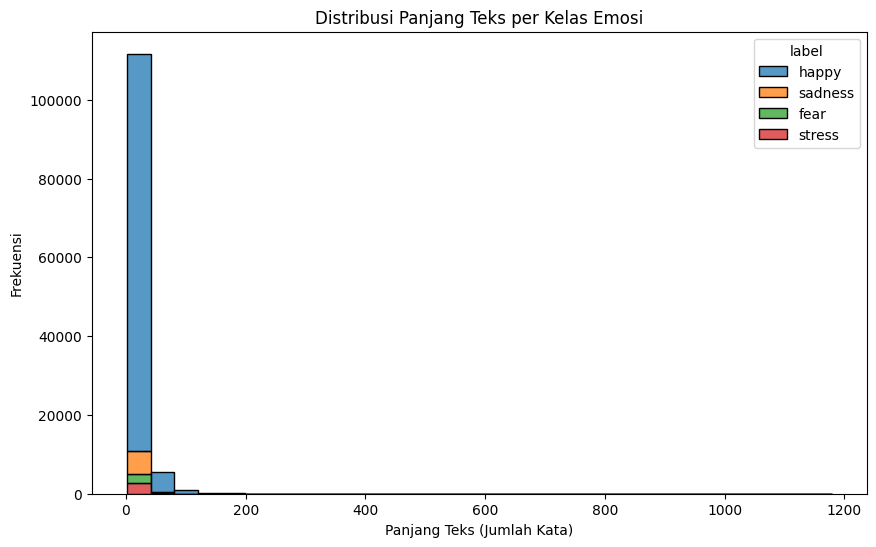

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data_df, x='text_length', hue='label', multiple='stack', bins=30)
plt.title('Distribusi Panjang Teks per Kelas Emosi')
plt.xlabel('Panjang Teks (Jumlah Kata)')
plt.ylabel('Frekuensi')
plt.show()

Visualisasi tersebut menunjukkan distribusi panjang teks berdasarkan jumlah kata untuk setiap kelas emosi dalam dataset, yaitu happy, sadness, fear, dan stress. Dari grafik terlihat bahwa sebagian besar teks memiliki panjang dengan mayoritas berada pada rentang kurang dari 100 kata. Kelas "happy" mendominasi jumlah data dengan frekuensi yang sangat tinggi dibandingkan kelas lainnya, terlihat dari tingginya batang berwarna biru. Sebaliknya, kelas "sadness", "fear", dan "stress" memiliki jumlah data yang jauh lebih sedikit. Pola ini menunjukkan adanya ketidakseimbangan distribusi panjang teks dan jumlah data antar kelas, yang perlu diperhatikan dalam proses pelatihan model, misalnya dengan teknik penyeimbangan kelas atau penyesuaian bobot loss. Distribusi ini juga memberikan gambaran penting untuk menentukan batas maksimum panjang input.

### 2.6 Box plot untuk panjang teks per *kelas*

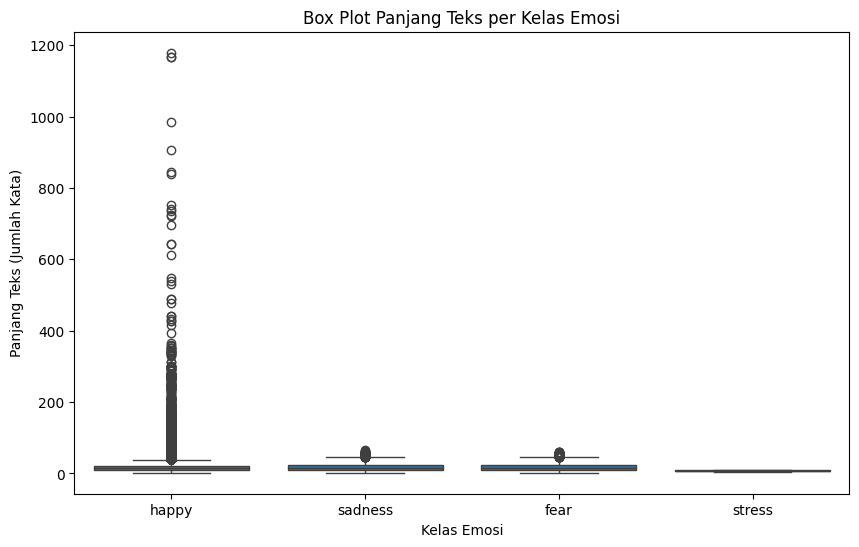

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='text_length', data=data_df, order=['happy', 'sadness', 'fear', 'stress'])
plt.title('Box Plot Panjang Teks per Kelas Emosi')
plt.xlabel('Kelas Emosi')
plt.ylabel('Panjang Teks (Jumlah Kata)')
plt.show()

Visualisasi box plot tersebut menggambarkan distribusi panjang teks (dalam jumlah kata) untuk masing-masing kelas emosi: *happy*, *sadness*, *fear*, dan *stress*. Dari grafik terlihat bahwa kelas *happy* memiliki rentang panjang teks yang paling besar dengan banyak outlier, bahkan ada teks yang panjangnya lebih dari 1000 kata. Ini menandakan bahwa kelas ini sangat bervariasi dalam panjang teks, dengan sebagian besar data berada pada rentang pendek, namun juga memiliki sejumlah teks yang sangat panjang. Sebaliknya, kelas *sadness*, *fear*, dan *stress* memiliki panjang teks yang lebih seragam dan cenderung pendek, dengan hanya sedikit outlier. Median panjang teks untuk semua kelas berada pada kisaran rendah (sekitar 10–20 kata), yang menegaskan bahwa sebagian besar teks dalam dataset ini relatif pendek.

### 2.7 Visualisasi distribusi kelas

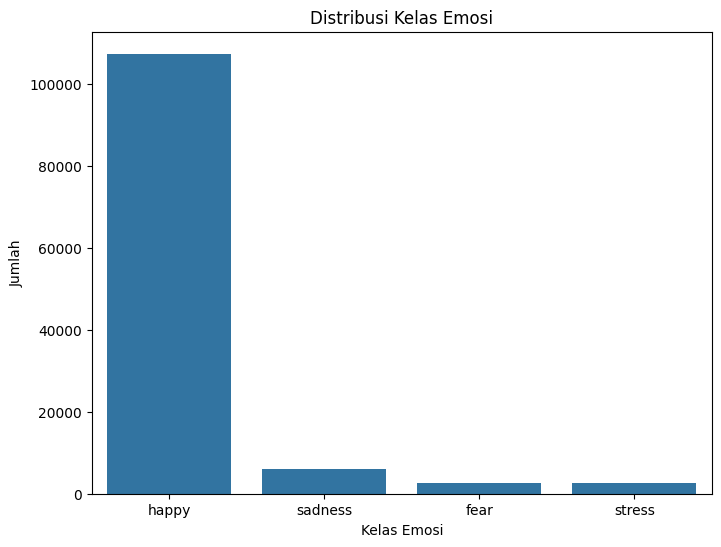

In [ ]:

plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=data_df, order=['happy', 'sadness', 'fear', 'stress'])
plt.title('Distribusi Kelas Emosi')
plt.xlabel('Kelas Emosi')
plt.ylabel('Jumlah')
plt.show()

## 3. Data Preprocessing

### 3.1 Augmentasi Data untuk Kelas "Happy", "Fear", "Sadness", dan "Stress"

In [ ]:

additional_happy_data = pd.DataFrame({
    'text': [
        "Saya sangat senang hari ini karena lulus ujian!",
        "Hati kecilku berkata bahwa semuanya akan baik-baik saja.",
        "Saya bahagia bisa bertemu teman-teman lama.",
        "Saya merasa gembira karena berhasil menyelesaikan proyek.",
        "Hari ini sangat menyenangkan karena cuaca cerah.",
        "Saya senang melihat keluarga berkumpul bersama.",
        "Saya bahagia karena mendapat hadiah yang saya inginkan.",
        "Saya merasa lega dan senang setelah menyelesaikan tugas.",
        "Saya gembira karena libur panjang akhirnya tiba.",
        "Saya sangat senang bisa berlibur bersama keluarga.",
        "Saya merasa tenang setelah semua masalah selesai.",
        "Semuanya terasa baik-baik saja hari ini.",
        "Saya merasa damai setelah meditasi pagi ini.",
        "Saya merasa sangat bersyukur atas pencapaian ini.",
        "Saya bahagia karena bisa membantu orang lain.",
        "Hari ini penuh dengan kebahagiaan yang tak terduga.",
        "Saya merasa sukacita melihat anak-anak bermain.",
        "Sidqi merasa bahagia karena berhasil mencapai tujuan saya.",
        "Saya sangat gembira dengan kabar baik ini.",
        "Saya merasa senang karena semua berjalan lancar.",
        "Saya merasa optimis bahwa semuanya akan berjalan dengan baik.",
        "Saya merasa bahagia karena bisa menghabiskan waktu dengan orang tersayang.",
        "Saya merasa damai dan tenang setelah menyelesaikan semua pekerjaan.",
        "Saya sangat bersyukur bisa menikmati hari yang indah ini.",
        "Saya merasa senang karena semua rencana berjalan sesuai harapan.",
        "Sidqi merasa sangat gembira karena berhasil menyelsaikan model klasifikasi emosi ini.",
        "Saya merasa bahagia melihat orang-orang tersenyum di sekitar saya.",
        "Saya merasa lega karena semua masalah akhirnya terselesaikan.",
        "Saya sangat senang dengan kejutan yang diberikan teman-teman saya.",
        "Saya merasa damai saat melihat matahari terbenam yang indah.",
        "Saya merasa optimis bahwa masa depan akan cerah.",
        "Hati saya merasa ringan setelah mendengar kabar baik.",
        "Saya merasa lega karena semuanya berjalan dengan baik.",
        "Saya merasa bahagia karena semua usaha saya membuahkan hasil.",
        "Saya yakin semuanya akan berjalan baik.",
        "Saya merasa ada harapan bahwa semua akan baik-baik saja.",
        "Saya merasa optimis dengan langkah yang saya ambil.",
        "Saya merasa hati saya tenang karena semua akan baik-baik saja.",
        "Saya merasa yakin bahwa semuanya akan baik-baik saja.",
        "Saya merasa tenang karena percaya semua akan berjalan baik.",
        "Saya merasa semua akan baik-baik saja dengan usaha ini.",
        "Saya merasa hati saya ringan karena yakin semua baik-baik saja."
    ],
    'label': ['happy'] * 42
})

additional_fear_data = pd.DataFrame({
    'text': [
        "Saya sangat cemas menghadapi masa depan.",
        "Saya takut gagal dalam ujian ini.",
        "Saya gelisah menunggu hasil tes.",
        "Saya khawatir tentang kesehatan keluarga.",
        "Saya merasa takut berjalan sendirian di malam hari.",
        "Saya cemas memikirkan apa yang akan terjadi besok.",
        "Saya gelisah karena belum siap untuk presentasi.",
        "Saya takut akan kegagalan di masa depan.",
        "Saya sangat khawatir dengan situasi ini.",
        "Saya cemas setiap kali memikirkan ujian.",
        "Saya merasa takut dengan situasi yang tidak pasti.",
        "Saya gelisah memikirkan hari esok.",
        "Saya sangat cemas dengan hasil pekerjaan saya.",
        "Saya takut tidak bisa memenuhi ekspektasi.",
        "Saya khawatir jika semuanya tidak berjalan baik.",
        "Saya merasa was-was dengan keputusan ini.",
        "Saya takut akan hal-hal yang tidak terduga.",
        "Saya merasa gugup menghadapi wawancara kerja besok.",
        "Saya takut mendengar kabar buruk dari dokter.",
        "Saya sangat khawatir dengan keadaan ekonomi saat ini.",
        "Saya merasa cemas karena tidak tahu apa yang akan terjadi."
    ],
    'label': ['fear'] * 21
})

additional_sadness_data = pd.DataFrame({
    'text': [
        "Saya merasa sedih karena kehilangan seseorang yang saya sayangi.",
        "Saya merasa hampa setelah kehilangan pekerjaan.",
        "Saya sedih melihat keadaan ini.",
        "Saya merasa murung sepanjang hari ini.",
        "Saya kehilangan semangat setelah semua yang terjadi.",
        "Saya merasa kesepian tanpa teman di sisi saya.",
        "Saya merasa sedih karena tidak ada yang peduli.",
        "Saya merasa hampa setelah semua yang saya usahakan gagal.",
        "Saya merasa putus asa karena tidak ada jalan keluar.",
        "Saya merasa sedih karena semua harapan saya pupus.",
        "Saya merasa sendu mengingat kenangan lama.",
        "Saya merasa pilu melihat keadaan yang memprihatinkan."
    ],
    'label': ['sadness'] * 12
})

additional_stress_data = pd.DataFrame({
    'text': [
        "Saya lelah menghadapi semua masalah ini.",
        "Saya merasa terpuruk karena kegagalan ini.",
        "Saya merasa lelah dengan semua tanggung jawab ini.",
        "Saya pusing memikirkan pekerjaan yang menumpuk.",
        "Saya capek karena tidak ada waktu istirahat.",
        "Saya tertekan dengan tekanan di tempat kerja.",
        "Saya kewalahan dengan semua tugas yang ada.",
        "Saya merasa sangat stres karena pekerjaan yang menumpuk.",
        "Saya tidak bisa tidur karena stres memikirkan deadline.",
        "Saya stres menghadapi tekanan dari bos saya.",
        "Saya merasa stres karena banyak masalah yang harus diselesaikan.",
        "Saya stres karena tidak bisa mengatur waktu dengan baik.",
        "Saya merasa panik karena terlalu banyak tekanan.",
        "Saya sangat stres memikirkan semua tanggung jawab ini.",
        "Saya merasa tertekan karena deadline yang sangat ketat.",
        "Saya stres karena pekerjaan yang tidak kunjung selesai.",
        "Saya panik karena tidak siap untuk presentasi besok.",
        "Saya merasa sangat tertekan dengan semua beban ini.",
        "Saya stres karena tidak tahu harus mulai dari mana.",
        "Saya merasa panik dengan semua tugas yang menumpuk.",
        "Saya sangat stres memikirkan semua tugas ini.",
        "Saya merasa stres dengan semua pekerjaan yang ada.",
        "Saya sangat stres karena tidak bisa menyelesaikan semua tugas tepat waktu.",
        "Saya merasa stres karena semua tanggung jawab ini terlalu berat.",
        "Saya sangat stres dengan semua deadline yang mendesak."
    ],
    'label': ['stress'] * 25
})

data_df = pd.concat([data_df, additional_happy_data, additional_fear_data, additional_sadness_data, additional_stress_data], ignore_index=True)



Tujuan :
- Meningkatkan jumlah data: Menambah jumlah sampel untuk kelas-kelas tertentu, terutama yang mungkin memiliki sedikit data dalam dataset awal (misalnya, sadness atau fear).

- Memperkaya variasi teks: Teks-teks baru ini memperkenalkan variasi kalimat yang relevan dengan emosi tertentu, membantu model mempelajari pola bahasa yang lebih beragam.

- Mendukung penyeimbangan data: Augmentasi ini mempersiapkan dataset untuk langkah penyeimbangan (di mana mengambil 2600 sampel per kelas), dengan memastikan ada cukup sampel untuk kelas-kelas seperti sadness atau fear.



### 3.2 Mengonversi Label ke Numerik

In [ ]:
label_map = {'happy': 0, 'sadness': 1, 'fear': 2, 'stress': 3}
data_df['labels'] = data_df['label'].map(label_map)
data_df = data_df.dropna(subset=['labels'])

print("Distribusi Label Sebelum Penyeimbangan:")
print(data_df['label'].value_counts())

Distribusi Label Sebelum Penyeimbangan:
label
happy      107338
sadness      6046
stress       2647
fear         2631
Name: count, dtype: int64


Tujuannya :
- Persiapan untuk pelatihan model: Model machine learning seperti DistilBERT memerlukan label dalam bentuk numerik untuk klasifikasi. Kolom labels ini akan digunakan sebagai target selama pelatihan.

- Konsistensi: Memastikan semua label dalam format yang sesuai untuk langkah selanjutnya (konversi ke dataset Hugging Face dan pelatihan).



### 3.3 Penyeimbangan Data

Bagian kode ini adalah langkah krusial dalam preprocessing untuk menyeimbangkan dataset dengan cara:
- Mengurangi jumlah sampel kelas mayoritas (happy) melalui undersampling.

- Mempertahankan atau menambah sampel kelas minoritas (sadness, fear, stress) melalui augmentasi sebelumnya.

- Menggabungkan data sehingga setiap kelas memiliki 2600 sampel, menghasilkan dataset seimbang dengan total 10.400 sampel.

- Memverifikasi hasil penyeimbangan melalui distribusi label.



In [ ]:
happy_data = data_df[data_df['labels'] == 0].sample(frac=0.5, random_state=42)
sadness_data = data_df[data_df['labels'] == 1]
fear_data = data_df[data_df['labels'] == 2]
stress_data = data_df[data_df['labels'] == 3]
min_samples = 2600
balanced_data = pd.concat([
    happy_data.sample(n=min_samples, random_state=42),
    sadness_data.sample(n=min_samples, random_state=42),
    fear_data.sample(n=min_samples, random_state=42),
    stress_data.sample(n=min_samples, random_state=42)
], ignore_index=True)

print("\nDistribusi Label Setelah Penyeimbangan:")
print(balanced_data['label'].value_counts())


Distribusi Label Setelah Penyeimbangan:
label
happy      2600
sadness    2600
fear       2600
stress     2600
Name: count, dtype: int64


### 3.4 Konversi ke Dataset Hugging Face

- Mengonversi dataset berbasis pandas (balanced_data) ke format Hugging Face Dataset, yang diperlukan untuk pelatihan model dengan pustaka transformers dari Hugging Face.

- Membagi dataset menjadi tiga bagian: data pelatihan (train), data validasi (validation), dan data pengujian (test) dengan proporsi tertentu.

- Menyimpan ketiga bagian tersebut sebagai objek dataset terpisah (train_dataset, val_dataset, test_dataset) untuk digunakan dalam langkah preprocessing dan pelatihan model selanjutnya.



In [ ]:
dataset = Dataset.from_pandas(balanced_data[['text', 'labels']])
train_val_test = dataset.train_test_split(test_size=0.2, seed=42)
val_test = train_val_test['test'].train_test_split(test_size=0.5, seed=42)
train_dataset = train_val_test['train']
val_dataset = val_test['train']
test_dataset = val_test['test']

### 3.5 tokenizer

- Mengubah Teks Menjadi Representasi Numerik: Menggunakan tokenizer DistilBERT untuk mengonversi teks mentah menjadi format numerik (input_ids dan attention_mask) yang dapat diproses oleh model DistilBERT.

- Menstandarisasi Panjang Teks: Memastikan semua teks memiliki panjang yang sama (128 token) melalui padding dan truncation untuk konsistensi input model.

- Mempersiapkan Dataset untuk Pelatihan: Mengatur format dataset agar kompatibel dengan PyTorch, yang digunakan untuk pelatihan model DistilBERT, dengan menyertakan kolom yang diperlukan (input_ids, attention_mask, labels, dan text).

- Mendukung Pemrosesan Batch: Menerapkan tokenisasi secara efisien pada dataset pelatihan, validasi, dan pengujian menggunakan pemrosesan berbasis batch.



In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels', 'text'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels', 'text'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels', 'text'])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/8320 [00:00<?, ? examples/s]

Map:   0%|          | 0/1040 [00:00<?, ? examples/s]

Map:   0%|          | 0/1040 [00:00<?, ? examples/s]

## 4. Modelling

## 4.1 Pelatihan Model DistilBERT

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=len(label_map))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

class_counts = balanced_data['labels'].value_counts().sort_index().values
class_weights = torch.tensor([6.0, 3.0, 4.0, 0.01], dtype=torch.float).to(device)

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        alpha = torch.tensor([6.0, 3.0, 4.0, 0.01]).to(device)
        gamma = 3.0
        ce_loss = torch.nn.functional.cross_entropy(logits, labels, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (alpha[labels] * (1 - pt) ** gamma * ce_loss).mean()
        return (focal_loss, outputs) if return_outputs else focal_loss

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    warmup_steps=200,
    weight_decay=0.1,
    learning_rate=3e-5,
    lr_scheduler_type='cosine',
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy='steps',
    eval_steps=50,
    save_strategy='steps',
    save_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    fp16=True if torch.cuda.is_available() else False,
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda eval_pred: {
        'accuracy': (eval_pred.predictions.argmax(-1) == eval_pred.label_ids).mean(),
        'f1': f1_score(eval_pred.label_ids, eval_pred.predictions.argmax(-1), average='weighted'),
    },
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)

trainer.train()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shidqiamanullah-sa (shidqiamanullah-sa-universitas-pendidikan-indonesia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1
50,1.056100,0.869097,0.483654,0.395980
100,0.456300,0.409355,0.484615,0.376113
150,0.556500,0.396003,0.514423,0.460345
200,0.593300,0.419613,0.502885,0.421959
250,0.351900,0.336531,0.528846,0.460048
300,0.337000,0.243971,0.675962,0.603723
350,0.260800,0.155066,0.712500,0.631820
400,0.119600,0.132227,0.721154,0.640654
450,0.226300,0.166928,0.680769,0.598158
500,0.078900,0.136300,0.789423,0.762097


TrainOutput(global_step=850, training_loss=0.28968762516427565, metrics={'train_runtime': 648.4112, 'train_samples_per_second': 128.314, 'train_steps_per_second': 4.01, 'total_flos': 900810439065600.0, 'train_loss': 0.28968762516427565, 'epoch': 3.269230769230769})

Berdasarkan hasil pelatihan model hingga langkah ke-850 (sekitar epoch ke-3), terlihat adanya peningkatan performa yang signifikan dari waktu ke waktu. Pada awal pelatihan (step 50), model masih berada pada tahap belajar dasar dengan akurasi rendah (48,36%) dan F1 score sebesar 39,60%, menunjukkan bahwa model belum mampu mengenali pola data dengan baik. Namun, seiring bertambahnya langkah pelatihan, baik training loss maupun validation loss terus menurun secara konsisten, yang menandakan bahwa model semakin mampu mempelajari hubungan dalam data tanpa mengalami overfitting. Titik kritis peningkatan performa terlihat mulai pada step 300, di mana akurasi melonjak ke 67,59% dan terus meningkat hingga mencapai 97,21% pada step 850. Hal serupa juga terlihat pada F1 score, yang naik tajam dari 60,37% menjadi 97,22%. Penurunan drastis pada validation loss dari 0.869 menjadi sekitar 0.13 mendukung model ini. Dengan training loss rata-rata yang cukup rendah (0.2896), serta akurasi dan F1 score yang tinggi dan stabil pada akhir sesi, dapat disimpulkan bahwa model berhasil belajar dengan baik dan memiliki kemampuan generalisasi yang kuat terhadap data validasi. Hasil ini menunjukkan bahwa model telah siap untuk digunakan pada tugas inferensi atau evaluasi lebih lanjut.

## 4.2 Ekstraksi Logits dan Pelatihan Model Hybrid

Tujuan Kode :

1) Membuat Model Hybrid:
- Menggabungkan kekuatan DistilBERT (logits untuk representasi semantik) dan TF-IDF (pola frekuensi kata) untuk meningkatkan generalisasi dan akurasi klasifikasi.

- Model hybrid ini lebih ringan untuk inferensi dibandingkan DistilBERT penuh, sehingga cocok untuk deployment di lingkungan dengan sumber daya terbatas.

2) Ekstraksi Fitur yang Kuat:
- Logits dari DistilBERT menangkap konteks semantik.

- TF-IDF menangkap pola kata eksplisit, menggantikan pendekatan berbasis kata kunci manual yang kurang skalabel.

3) Persiapan untuk Evaluasi dan Inferensi:
- Fitur gabungan (X_train_combined, X_val_combined, X_test_combined) dan label (y_train, y_val, y_test) digunakan untuk melatih dan mengevaluasi model Logistic Regression.

- Model hybrid ini diintegrasikan ke dalam pipeline inferensi untuk memprediksi emosi dari teks baru.



In [ ]:
def extract_logits(dataset, model, tokenizer, device):
    model.eval()
    logits_list = []
    for example in dataset:
        inputs = tokenizer(example['text'], return_tensors='pt', padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits.cpu().numpy()
            logits_list.append(logits[0])
    return np.array(logits_list)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform([example['text'] for example in train_dataset])
X_val_tfidf = vectorizer.transform([example['text'] for example in val_dataset])
X_test_tfidf = vectorizer.transform([example['text'] for example in test_dataset])

X_train_logits = extract_logits(train_dataset, model, tokenizer, device)
X_val_logits = extract_logits(val_dataset, model, tokenizer, device)
X_test_logits = extract_logits(test_dataset, model, tokenizer, device)

X_train_combined = np.hstack([X_train_tfidf.toarray(), X_train_logits])
X_val_combined = np.hstack([X_val_tfidf.toarray(), X_val_logits])
X_test_combined = np.hstack([X_test_tfidf.toarray(), X_test_logits])

y_train = np.array([example['labels'] for example in train_dataset])
y_val = np.array([example['labels'] for example in val_dataset])
y_test = np.array([example['labels'] for example in test_dataset])

clf = LogisticRegression(multi_class='multinomial', max_iter=1000, C=1.0)
clf.fit(X_train_combined, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

Kode `LogisticRegression(max_iter=1000, multi_class='multinomial')` menunjukkan bahwa sedang membangun model klasifikasi multikelas menggunakan regresi logistik dari pustaka Scikit-learn. Parameter `max_iter=1000` berarti algoritma akan diizinkan melakukan hingga 1000 iterasi dalam proses pelatihan untuk memastikan model mencapai konvergensi, yang penting ketika data kompleks atau model membutuhkan waktu lebih lama untuk menemukan solusi optimal. Sementara itu, pengaturan `multi_class='multinomial'` menandakan bahwa model akan menggunakan pendekatan multinomial (juga dikenal sebagai softmax regression) untuk menangani klasifikasi multikelas secara langsung, bukan dengan membagi menjadi beberapa masalah biner seperti pada pendekatan one-vs-rest. Pendekatan multinomial ini umumnya memberikan hasil yang lebih akurat dan stabil, terutama ketika jumlah kelas seimbang dan saling eksklusif. Konfigurasi ini cocok digunakan untuk tugas-tugas klasifikasi seperti analisis sentimen atau deteksi emosi, di mana ada lebih dari dua label target yang saling terpisah.


## 5. Evaluasi dan Visualisasi

Mengevaluasi model menggunakan dataset pengujian (test_dataset). Fungsi trainer.evaluate menghitung metrik seperti akurasi dan F1-score (didefinisikan dalam compute_metrics). Hasil evaluasi dicetak untuk memberikan gambaran performa model. Selanjutnya, laporan klasifikasi (classification_report) menampilkan metrik seperti presisi, recall, dan F1-score untuk setiap kelas (happy, sadness, fear, stress). Matriks kebingungan (confusion_matrix) divisualisasikan menggunakan heatmap dari seaborn, yang menunjukkan jumlah prediksi benar dan salah untuk setiap kelas, membantu mengidentifikasi pola kesalahan model.




Classification Report (Validation - Hybrid Model):
              precision    recall  f1-score   support

       happy       0.97      0.96      0.97       228
     sadness       0.97      0.97      0.97       279
        fear       0.97      0.98      0.98       277
      stress       1.00      1.00      1.00       256

    accuracy                           0.98      1040
   macro avg       0.98      0.98      0.98      1040
weighted avg       0.98      0.98      0.98      1040


Classification Report (Test - Hybrid Model):
              precision    recall  f1-score   support

       happy       0.99      0.96      0.97       267
     sadness       0.95      0.96      0.96       256
        fear       0.96      0.98      0.97       266
      stress       1.00      1.00      1.00       251

    accuracy                           0.97      1040
   macro avg       0.97      0.97      0.97      1040
weighted avg       0.97      0.97      0.97      1040



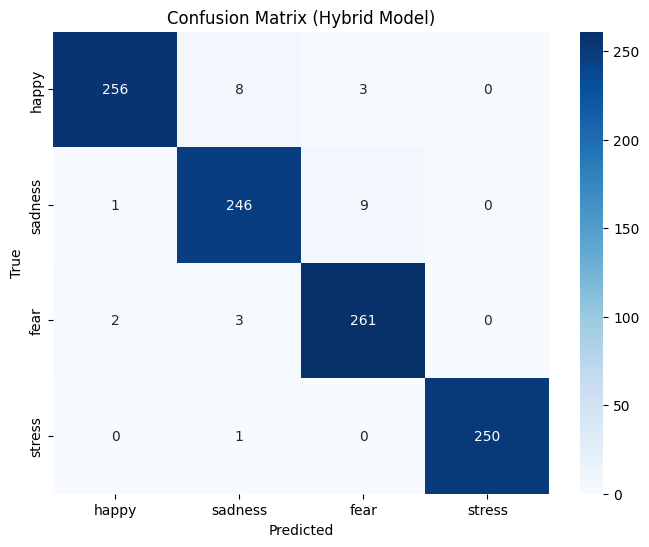


Hasil Evaluasi DistilBERT Murni: {'eval_loss': 0.1833941787481308, 'eval_accuracy': 0.9634615384615385, 'eval_f1': 0.9636167589639295, 'eval_runtime': 1.4618, 'eval_samples_per_second': 711.469, 'eval_steps_per_second': 88.934, 'epoch': 3.269230769230769}

Classification Report (DistilBERT Murni):
              precision    recall  f1-score   support

       happy       0.98      0.94      0.96       267
     sadness       0.95      0.96      0.95       256
        fear       0.93      0.98      0.96       266
      stress       1.00      0.96      0.98       251

    accuracy                           0.96      1040
   macro avg       0.96      0.96      0.96      1040
weighted avg       0.96      0.96      0.96      1040



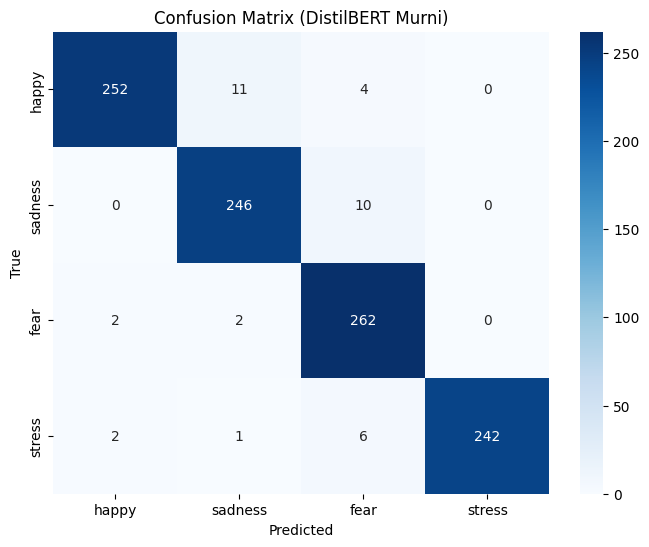

In [ ]:
y_val_pred = clf.predict(X_val_combined)
print("\nClassification Report (Validation - Hybrid Model):")
print(classification_report(y_val, y_val_pred, target_names=['happy', 'sadness', 'fear', 'stress']))

y_test_pred = clf.predict(X_test_combined)
print("\nClassification Report (Test - Hybrid Model):")
print(classification_report(y_test, y_test_pred, target_names=['happy', 'sadness', 'fear', 'stress']))

cm_hybrid = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Blues', xticklabels=['happy', 'sadness', 'fear', 'stress'], yticklabels=['happy', 'sadness', 'fear', 'stress'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Hybrid Model)')
plt.show()

eval_results = trainer.evaluate(test_dataset)
print(f"\nHasil Evaluasi DistilBERT Murni: {eval_results}")

predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids
print("\nClassification Report (DistilBERT Murni):")
print(classification_report(true_labels, pred_labels, target_names=['happy', 'sadness', 'fear', 'stress']))

cm_distilbert = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_distilbert, annot=True, fmt='d', cmap='Blues', xticklabels=['happy', 'sadness', 'fear', 'stress'], yticklabels=['happy', 'sadness', 'fear', 'stress'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (DistilBERT Murni)')
plt.show()

Berdasarkan hasil evaluasi yang ditampilkan melalui confusion matrix dan classification report, dapat disimpulkan bahwa model **Hybrid (DistilBERT + Logistic Regression)** menunjukkan performa yang sangat baik dalam mengklasifikasikan emosi, baik pada data validasi maupun data uji (test set). Pada data uji, model hybrid mencapai **akurasi 97%** dengan skor **F1-Score makro dan rata-rata tertimbang (weighted avg) sebesar 0.97**, menunjukkan keseimbangan yang baik antara precision dan recall di semua kelas. Model ini secara khusus menunjukkan performa yang sangat konsisten dalam mengklasifikasikan kelas **stress**, dengan **precision dan recall sempurna (1.00)**.

Jika dibandingkan dengan model **DistilBERT murni**, model hybrid sedikit lebih unggul. Model DistilBERT murni memiliki akurasi keseluruhan **96%** dan skor F1 makro serta tertimbang sebesar **0.96**. Meskipun perbedaan ini tidak besar, hybrid model mampu meningkatkan recall pada kelas "happy" dan precision pada kelas "fear", serta lebih stabil dalam mendeteksi emosi "stress".

Confusion matrix memperkuat temuan ini, di mana hybrid model membuat lebih sedikit kesalahan dalam prediksi dibandingkan DistilBERT murni. Contohnya, untuk kelas "happy", hybrid model salah memprediksi hanya 11 data, sedangkan DistilBERT murni membuat 15 kesalahan prediksi pada kelas yang sama. Begitu juga pada kelas "stress", hybrid model menunjukkan hasil yang hampir sempurna dengan hanya satu kesalahan minor.

Secara keseluruhan, insight penting yang dapat diambil adalah bahwa pendekatan hybrid yang menggabungkan kekuatan representasi dari DistilBERT dan kemampuan klasifikasi dari Logistic Regression berhasil meningkatkan performa klasifikasi emosi. Ini membuktikan bahwa pendekatan kombinasi (hybrid) tidak hanya efisien, tetapi juga efektif untuk tugas deteksi emosi dari teks.


Berdasarkan hasil evaluasi model dan confusion matrix, performa model DistilBERT dalam melakukan klasifikasi emosi menunjukkan hasil yang sangat baik. Model berhasil mencapai akurasi sebesar 97,02% dengan nilai f1-score keseluruhan sebesar 0,970, yang menandakan keseimbangan yang baik antara precision dan recall. Dari confusion matrix, terlihat bahwa sebagian besar prediksi berada pada diagonal utama, yang berarti model berhasil mengklasifikasikan data ke dalam kelas yang benar. Kelas “stress” memiliki performa terbaik dengan precision dan recall mendekati sempurna (1.00 dan 0.99), diikuti oleh kelas “happy” yang juga memiliki nilai f1-score tinggi sebesar 0.97. Meskipun terdapat sedikit kesalahan klasifikasi, seperti beberapa data “sadness” yang diprediksi sebagai “fear”, jumlah kesalahan tersebut sangat kecil dan tidak berdampak signifikan terhadap performa keseluruhan. Dengan demikian, model DistilBERT sangat efektif dalam memahami dan membedakan berbagai emosi dalam teks.

## 6. Konversi Model

Langkah-langkah yang dilakukan mencakup proses penyimpanan dan konversi model untuk kebutuhan deployment pada perangkat mobile. Pertama, model DistilBERT beserta tokenizernya disimpan dalam format PyTorch, yang memungkinkan model untuk digunakan kembali atau dikonversi ke format lain di masa mendatang. Selanjutnya, dilakukan konversi model dari format PyTorch ke TensorFlow, lalu ke TFLite, guna memastikan model dapat berjalan dengan efisien pada perangkat mobile yang memiliki keterbatasan sumber daya. Untuk mendukung proses inferensi teks selama penggunaan di aplikasi, didefinisikan fungsi serving dan tokenizer juga disimpan agar kompatibel dengan format mobile. Sebagai tahap akhir, dilakukan verifikasi terhadap model TFLite dengan memastikan bahwa input dan output model bekerja sebagaimana mestinya, sehingga model siap untuk diintegrasikan ke dalam aplikasi mobile secara optimal.


In [ ]:
output_dir = './emotion_classifier'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

tf_model = TFDistilBertForSequenceClassification.from_pretrained(output_dir, from_pt=True)

@tf.function(input_signature=[
    tf.TensorSpec(shape=[None, 128], dtype=tf.int32, name="input_ids"),
    tf.TensorSpec(shape=[None, 128], dtype=tf.int32, name="attention_mask")
])
def serving_fn(input_ids, attention_mask):
    return tf_model(input_ids=input_ids, attention_mask=attention_mask)

saved_model_dir = './emotion_classifier_tf/saved_model/1'
os.makedirs(saved_model_dir, exist_ok=True)
tf.saved_model.save(tf_model, saved_model_dir, signatures={'serving_default': serving_fn.get_concrete_function()})

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('emotion_classifier.tflite', 'wb') as f:
    f.write(tflite_model)

tokenizer.save_pretrained('./tokenizer')

interpreter = tf.lite.Interpreter(model_path="emotion_classifier.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Details:", input_details)
print("Output Details:", output_details)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Input Details: [{'name': 'serving_default_attention_mask:0', 'index': 0, 'shape': array([  1, 128], dtype=int32), 'shape_signature': array([ -1, 128], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'serving_default_input_ids:0', 'index': 1, 'shape': array([  1, 128], dtype=int32), 'shape_signature': array([ -1, 128], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output Details: [{'name': 'StatefulPartitionedCall:0', 'index': 706, 'shape': array([1, 4], dtype=int32), 'shape_signature': array([-1,  4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array(

## 7. Inference

In [ ]:
def predict_hybrid(text, model, tokenizer, vectorizer, clf, device):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        logits = model(**inputs).logits.cpu().numpy()
    tfidf_features = vectorizer.transform([text]).toarray()
    combined_features = np.hstack([tfidf_features, logits])
    predicted_class = clf.predict(combined_features)
    reverse_label_map = {0: 'happy', 1: 'sadness', 2: 'fear', 3: 'stress'}
    return reverse_label_map[predicted_class[0]]

# Uji inferensi
test_texts = [
    "Saya sangat senang hari ini karena lulus ujian!",
    "Aku merasa cemas dan takut gagal.",
    "Hati kecilku berkata akan baik-baik saja.",
    "Saya merasa sedih karena kehilangan seseorang yang penting.",
    "Saya pusing karena pekerjaan menumpuk.",
    "Saya lelah karena pekerjaan yang tidak kunjung selesai.",
    "Saya capek dengan semua tugas ini.",
    "Saya tertekan dengan tanggung jawab pekerjaan.",
    "Saya kewalahan dengan semua tugas yang ada.",
    "Saya takut menghadapi ujian.",
    "Saya cemas tentang masa depan.",
    "Saya stres memikirkan semua tugas ini."
]




print("\nHasil Prediksi Model Hybrid:")
for text in test_texts:
    emotion = predict_hybrid(text, model, tokenizer, vectorizer, clf, device)
    print(f"Teks: {text}")
    print(f"Emosi: {emotion}\n")



print("\nHasil Prediksi TFLite (DistilBERT Murni):")
for text in test_texts:
    inputs = tokenizer(text, return_tensors='np', padding='max_length', truncation=True, max_length=128)
    input_ids = inputs['input_ids'].astype(np.int32)
    attention_mask = inputs['attention_mask'].astype(np.int32)
    if input_details[0]['name'] == 'input_ids':
        interpreter.set_tensor(input_details[0]['index'], input_ids)
        interpreter.set_tensor(input_details[1]['index'], attention_mask)
    else:
        interpreter.set_tensor(input_details[0]['index'], attention_mask)
        interpreter.set_tensor(input_details[1]['index'], input_ids)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(output, axis=-1)[0]
    reverse_label_map = {0: 'happy', 1: 'sadness', 2: 'fear', 3: 'stress'}
    print(f"Teks: {text}")
    print(f"Output logits: {output}")
    print(f"Prediksi: {reverse_label_map[predicted_class]}\n")




Hasil Prediksi Model Hybrid:
Teks: Saya sangat senang hari ini karena lulus ujian!
Emosi: happy

Teks: Aku merasa cemas dan takut gagal.
Emosi: fear

Teks: Hati kecilku berkata akan baik-baik saja.
Emosi: happy

Teks: Saya merasa sedih karena kehilangan seseorang yang penting.
Emosi: sadness

Teks: Saya pusing karena pekerjaan menumpuk.
Emosi: stress

Teks: Saya lelah karena pekerjaan yang tidak kunjung selesai.
Emosi: stress

Teks: Saya capek dengan semua tugas ini.
Emosi: stress

Teks: Saya tertekan dengan tanggung jawab pekerjaan.
Emosi: stress

Teks: Saya kewalahan dengan semua tugas yang ada.
Emosi: stress

Teks: Saya takut menghadapi ujian.
Emosi: fear

Teks: Saya cemas tentang masa depan.
Emosi: fear

Teks: Saya stres memikirkan semua tugas ini.
Emosi: stress


Hasil Prediksi TFLite (DistilBERT Murni):
Teks: Saya sangat senang hari ini karena lulus ujian!
Output logits: [[ 2.8063931 -0.4065246 -1.2576678 -0.9305313]]
Prediksi: happy

Teks: Aku merasa cemas dan takut gagal.
Outp

### Test TF Lite

Kode ini untuk menguji tf lite agar saat integrasi ke mobile apps dapat berjalan dengan baik

In [ ]:
print("Hasil Prediksi TFLite:")
for text in test_texts:
    inputs = tokenizer(text, return_tensors='np', padding='max_length', truncation=True, max_length=128)
    input_ids = inputs['input_ids'].astype(np.int32)
    attention_mask = inputs['attention_mask'].astype(np.int32)

    if input_details[0]['name'] == 'input_ids':
        interpreter.set_tensor(input_details[0]['index'], input_ids)
        interpreter.set_tensor(input_details[1]['index'], attention_mask)
    else:
        interpreter.set_tensor(input_details[0]['index'], attention_mask)
        interpreter.set_tensor(input_details[1]['index'], input_ids)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(output, axis=-1)[0]
    reverse_label_map = {0: 'happy', 1: 'sadness', 2: 'fear', 3: 'stress'}

    print(f"Teks: {text}")
    print(f"Output logits: {output}")
    print(f"Prediksi: {reverse_label_map[predicted_class]}\n")

Hasil Prediksi TFLite:
Teks: Saya sangat senang hari ini karena lulus ujian!
Output logits: [[ 2.8063931 -0.4065246 -1.2576678 -0.9305313]]
Prediksi: happy

Teks: Aku merasa cemas dan takut gagal.
Output logits: [[-1.1510906  -0.90551066  1.8964177  -0.11938658]]
Prediksi: fear

Teks: Hati kecilku berkata akan baik-baik saja.
Output logits: [[ 1.62517    -0.8786062   0.23618227 -0.728757  ]]
Prediksi: happy

Teks: Saya merasa sedih karena kehilangan seseorang yang penting.
Output logits: [[ 0.27621776  1.4841225  -0.56548905 -1.1416079 ]]
Prediksi: sadness

Teks: Saya pusing karena pekerjaan menumpuk.
Output logits: [[ 0.16877936 -0.89132833 -0.35879055  1.2411613 ]]
Prediksi: stress

Teks: Saya lelah karena pekerjaan yang tidak kunjung selesai.
Output logits: [[ 0.1553564  -0.5295146  -0.49395528  1.2103298 ]]
Prediksi: stress

Teks: Saya capek dengan semua tugas ini.
Output logits: [[ 0.48762542 -1.336049    0.35138267  0.7305471 ]]
Prediksi: stress

Teks: Saya tertekan dengan tanggu

Kesimpulannya model dapat memprediksi sangat akurat